In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from method import IV
from simulator import Simulator
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import pandas as pd
import numpy as np
import quantities as pq
import seaborn as sns
from exana.statistics import plot_xcorr, permutation_resampling
from tools import savefig, fix_figure, coef_var, corrcoef, despine, set_style
import copy
from IPython.display import display
import statsmodels.api as sm

/home/mikkel/.virtualenvs/main/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def mean_square_error(x1, x2, norm=None):
    return np.sum((x2 - x1)**2) / len(x1.dropna())

def normalize(x, y):
    a = x - x.min()
    return a / a.max() * y.max()

In [3]:
trials = [5000, 10000, 15000, 20000, 25000, 30000]
sim_id = [1, 2, 3]
# path = 'results/orig_analysis/'
path = 'results/'

In [35]:
# iv_name = 'iv_cch'
iv_name = 'iv_wald'
varis = [iv_name, 'cch']
data = {var: {sid: list() for sid in sim_id} for var in varis}

for sid in sim_id:
    for N_trials in trials:
        analys = pd.read_csv(path + 'params_{}_analyse_{}.csv'.format(sid, N_trials))
        analys = analys.loc[(analys.pfast < 0.01) & (analys.ppeak < 0.01),:]
#         analys = analys.loc[(analys.pfast < 0.01),:]
        for var in varis:
            estimate, true = analys[var], analys['weight']
            true = normalize(true, estimate)
            data[var][sid].append(mean_square_error(estimate, true))

$g$ = 9.9 = -0.67
$g$ = 4.4 = -0.69
$g$ = 3.0 = -0.45


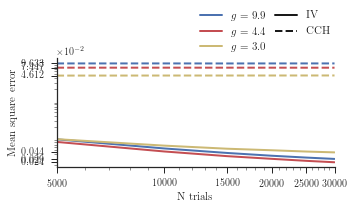

In [37]:
save = True
if save: set_style('article', sns_style='ticks')
if not save: set_style('notebook', sns_style='ticks')

fig, ax = plt.subplots()
legend = {
    1: '$g$ = 9.9',
    2: '$g$ = 4.4',
    3: '$g$ = 3.0'
}
color = {
    1: 'b',
    2: 'r',
    3: 'y'
}
h = []

for sid in sim_id:
    slope, intercept = np.polyfit(np.log(trials), np.log(data[iv_name][sid]), 1)
    print('{} = {:.2f}'.format(legend[sid], slope))
    a, = ax.loglog(trials, data[iv_name][sid], label=legend[sid], color=color[sid])
    ax.loglog(trials, data['cch'][sid], ls='--', color=color[sid])
    h.append(a)
    
despine(xticks=True, yticks=True, ax=ax)

import matplotlib.lines as mlines

iv = mlines.Line2D([], [], color='k', ls='-', label='IV')
cch = mlines.Line2D([], [], color='k', ls='--', label='CCH')
h.extend([iv,cch])
plt.legend(handles=h, bbox_to_anchor=(0.5, 1.02, .5, .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.xlabel('N trials')
plt.ylabel('Mean square error')



mins = sorted([np.min(data[v][sid]).round(5) for sid in sim_id for v in varis])
# del(mins[2])
ax.set_yticks(mins, minor=False)
ax.set_yticklabels(mins, minor=False)
from matplotlib.ticker import ScalarFormatter
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.ticklabel_format(style='sci', scilimits=(0,0))

ax.set_xlim([5000, 30000])
ax.set_xticks(np.arange(5000, 30000, 1000), minor=True)
ax.set_xticklabels([], minor=True)
ax.set_xticks(trials, minor=False)
ax.set_xticklabels(trials, minor=False)

if save: savefig(fig, 'mse', bbox_inches='tight')